In [1]:
import seaborn as sns
import numpy as np
from data import load_amp, load_uke
import pandas as pd
import warnings
from sklearn.metrics import RocCurveDisplay
import statsmodels.formula.api as smf

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
EXTRA_COVARIATES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "MoCA"]
SEED = 41
THRESHOLD = 10.9

def cast_to_float(data):
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors="coerce")
    return data


def preprocess_covariates(data):
    data = data.copy()
    data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
    data = cast_to_float(data)
    return data


def parse_data(y, covariates):
    data = pd.concat(
        (y[["Participant", "Study", "Visit ID", *PDQ_COLUMNS,
         *EXTRA_COVARIATES]], covariates[COVARIATES]), axis=1
    ).dropna(thresh=4 + len(COVARIATES) + len(EXTRA_COVARIATES))
    data["Visit ID"] = data["Visit ID"].str[1:].astype(int)
    data = data[data["Study"] != "HBS"]

    X = []
    y = []
    extra_data = []

    for _, data in data.sort_values(
        ["Participant", "Visit ID"], ascending=True
    ).groupby(["Participant"]):
        for iloc, (_, row) in enumerate(data.iterrows()):
            if iloc > 0:
                previous_row = data.iloc[iloc - 1]
                previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                    (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                ]
            else:
                previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

            X.append(
                previous_row + row[COVARIATES].to_list() + row[EXTRA_COVARIATES].to_list())
            y.append(row[PDQ_COLUMNS])
            extra_data.append([row["Study"]])

    return preprocess_covariates(
        pd.DataFrame(X, columns=PDQ_COLUMNS +
                     ["Time since last visit"] + COVARIATES + EXTRA_COVARIATES)
    ), cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS).reset_index(drop=True)), pd.DataFrame(extra_data, columns=["Study"])


# Load the AMP data
X_amp, covariates_amp = load_amp(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv",
    sample_one_measurement_per_subject=False,
)
X_amp, y_amp, extra_data_amp = parse_data(X_amp, covariates_amp)

# Load the UKE data
X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS + EXTRA_COVARIATES,
)

X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = preprocess_covariates(X_uke)[full_measurements_uke]
covariates_uke = covariates_uke[full_measurements_uke]
extra_data_uke = extra_data_uke[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

included_predictions = (extra_data_amp["Study"] != "HBS") & (pd.isna(X_amp[PDQ_COLUMNS]).sum(axis=1) == 0) & (pd.isna(y_amp[PDQ_COLUMNS]).sum(axis=1) == 0)
y_amp = y_amp[included_predictions].reset_index(drop=True)
X_amp = X_amp[included_predictions].reset_index(drop=True)
extra_data_amp = extra_data_amp[included_predictions].reset_index(drop=True)

Optimization terminated successfully.
         Current function value: 0.122857
         Iterations 8


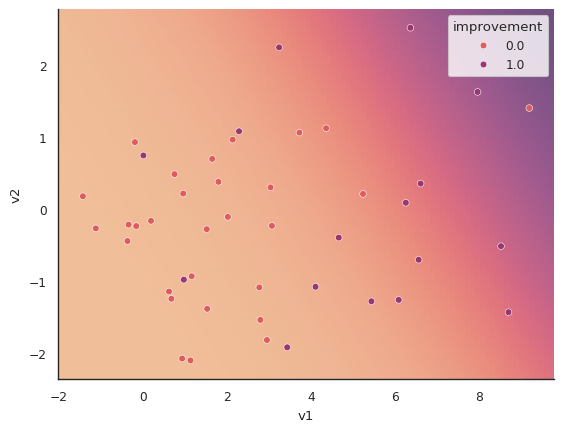

In [3]:
from sklearn.cross_decomposition import PLSRegression

regression = PLSRegression(n_components=2).fit(X_amp[PDQ_COLUMNS], y_amp[PDQ_COLUMNS])

# Create logistic regression on TRAINING data
X_amp_transformed = pd.DataFrame(regression.transform(X_amp[PDQ_COLUMNS]), columns=["v1", "v2"]).assign(improvement=(X_amp[PDQ_COLUMNS].mean(axis=1) - y_amp[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float))
amp_expected_change = smf.logit(
    "improvement ~ v1 + v2", data=X_amp_transformed
).fit()

# Predict UKE
prediction = pd.DataFrame(regression.transform(X_uke[PDQ_COLUMNS]), columns=["v1", "v2"])
prediction["improvement"] = (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float)

with sns.axes_style("white"):
    sns.set_context("paper")
    ax = sns.scatterplot(prediction, x="v1", y="v2", hue="improvement", palette="flare")
    
    XX, YY = np.meshgrid(np.linspace(*ax.get_xlim(), 100), np.linspace(*ax.get_ylim(), 100))
    coordinates = np.stack((XX, YY), axis=-1).reshape((-1, 2))
    predictions = amp_expected_change.predict(pd.DataFrame(coordinates, columns=["v1", "v2"])).to_numpy().reshape(XX.shape)
    ax.pcolormesh(XX, YY, predictions, shading="auto", alpha=0.8, zorder=-1, cmap="flare")
    
    sns.despine()

## Learn prediction on AMP data

In [4]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

estimator = HistGradientBoostingClassifier(
    random_state=SEED, class_weight="balanced")

params_distributions = dict(
    max_leaf_nodes=randint(low=2, high=50),
    max_depth=randint(low=1, high=20),
    max_iter=randint(low=10, high=100),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=50,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED),
    random_state=SEED,
    scoring="roc_auc"
)

X_amp_estimator_training = pd.concat((X_amp_transformed[["v1", "v2"]], X_amp[COVARIATES + EXTRA_COVARIATES]), axis=1)
optim_model.fit(X_amp_estimator_training, X_amp_transformed["improvement"])
estimator = optim_model.best_estimator_

estimator = CalibratedClassifierCV(estimator, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)).fit(X_amp_estimator_training, X_amp_transformed["improvement"])

## Try tro predict change without observing PDQ

<Axes: xlabel='v1_regressor', ylabel='v2_regressor'>

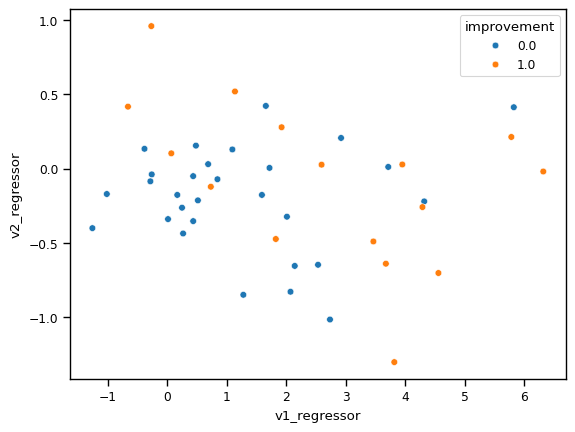

In [5]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(X_amp[COVARIATES + EXTRA_COVARIATES], regression.transform(X_amp[PDQ_COLUMNS]))

prediction_regressor = pd.DataFrame(regressor.predict(X_uke[COVARIATES + EXTRA_COVARIATES]), columns=["v1_regressor", "v2_regressor"])
prediction_regressor["improvement"] = (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float)
sns.scatterplot(prediction_regressor, x="v1_regressor", y="v2_regressor", hue="improvement")

Optimization terminated successfully.
         Current function value: 0.517388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564683
         Iterations 5


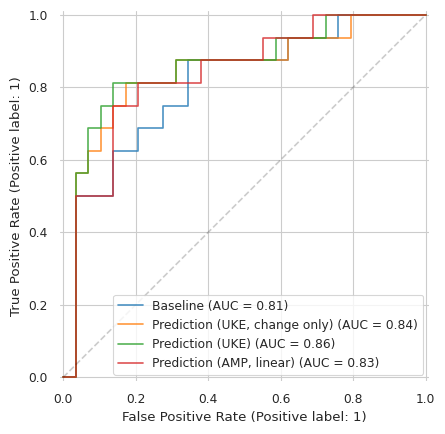

In [6]:
baseline_data = pd.DataFrame.from_dict(
    {
        "pre_pdq": X_uke[PDQ_COLUMNS].mean(axis=1),
        "updrs_iii_change": extra_data_uke["UPDRS III: Change"],
        "diagnosis_time": covariates_uke["Time since diagnosis"],
        "improvement": (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float),
    }
)

custom_data = pd.concat((prediction.drop(columns=["improvement"]), prediction_regressor.drop(columns=["improvement"]), baseline_data), axis=1).astype(float)
custom_data_nonna_columns = custom_data.columns
custom_data = pd.concat((custom_data, X_uke[COVARIATES + EXTRA_COVARIATES]), axis=1)
custom_data = custom_data.dropna(subset=custom_data_nonna_columns)

pdq_only = smf.logit(
    "improvement ~ pre_pdq", data=baseline_data
).fit()

baseline = smf.logit(
    "improvement ~ pre_pdq + updrs_iii_change + diagnosis_time", data=custom_data
).fit()

expected_change = smf.logit(
    "improvement ~ v1 + v2 + updrs_iii_change + diagnosis_time", data=custom_data
).fit()

expected_change_coefficients_only = smf.logit(
    "improvement ~ v1 + v2", data=custom_data
).fit()

expected_change_predicted = smf.logit(
    "improvement ~ v1_regressor + v2_regressor", data=custom_data
).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        baseline.predict(custom_data),
        name="Baseline",
        alpha=0.8
    )
    
    """
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        pdq_only.predict(custom_data),
        name="PDQ only",
        ax=viz.ax_
    )
    """
    
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        expected_change_coefficients_only.predict(custom_data),
        name="Prediction (UKE, change only)",
        ax=viz.ax_,
        alpha=0.8
    )
    
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        expected_change.predict(custom_data),
        name="Prediction (UKE)",
        ax=viz.ax_,
        alpha=0.8
    )
    
    """
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        expected_change_predicted.predict(custom_data),
        name="Prediction (Regressor)",
        ax=viz.ax_
    )
    """
    
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        amp_expected_change.predict(custom_data),
        name="Prediction (AMP, linear)",
        ax=viz.ax_,
        alpha=0.8
    )
    
    """
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        estimator.predict_proba(custom_data[X_amp_estimator_training.columns])[:, 1],
        name="Prediction (AMP, Ensemble)",
        ax=viz.ax_
    )
    """
    
    sns.despine(top=True, bottom=True, left=True, right=True)
    
    viz.ax_.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.2)